LOOK UP CODE IN WRANGLE WHERE 0'S ARE DELETED
---

imports
---

In [0]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
pip install -U scikit-learn scipy matplotlib

In [0]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import psutil
import os
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import pandas as pd
# import plotly_express as px
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

I am using a RAM intensive data, the following code lets me see how much RAM I am using.
---

In [0]:
# used to see how much RAM is being used
py = psutil.Process(os.getpid())
print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

RAM usage: 0.39781951904296875 GB


Function that helps optimize the data stored in my dataframes.
---

In [0]:
def reduce_mem_usage(df):
    """ 
        iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

Code used to read in csv files from Google Drive into colab.
---

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
data = 'https://drive.google.com/open?id=1-76gbkPzL5IedwIMo30EEHGIW7m0poKa'
fluff, id = data.split('=')
print (id) # Verify that you have everything after '=''
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('nba_logreg.csv') 

1-76gbkPzL5IedwIMo30EEHGIW7m0poKa


Code to show how much RAM each data frame uses before and after being passed through the optimization function.
---

In [11]:
print('-' * 80)
print('data')
nba = import_data('nba_logreg.csv')

--------------------------------------------------------------------------------
data
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.10 MB
Decreased by 52.8%


Printing the heads of the dataframes to see what each contains
---

In [50]:
print(nba.shape)
nba.head()

(1340, 21)


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.406250,7.398438,2.599609,7.601562,34.68750,0.500000,2.099609,25.00000,1.599609,2.300781,69.875,0.700195,3.400391,4.101562,1.900391,0.399902,0.399902,1.299805,0.0
1,Andrew Harrison,35,26.906250,7.199219,2.000000,6.699219,29.59375,0.700195,2.800781,23.50000,2.599609,3.400391,76.500,0.500000,2.000000,2.400391,3.699219,1.099609,0.500000,1.599609,0.0
2,JaKarr Sampson,74,15.296875,5.199219,2.000000,4.699219,42.18750,0.399902,1.700195,24.40625,0.899902,1.299805,67.000,0.500000,1.700195,2.199219,1.000000,0.500000,0.300049,1.000000,0.0
3,Malik Sealy,58,11.601562,5.699219,2.300781,5.500000,42.59375,0.099976,0.500000,22.59375,0.899902,1.299805,68.875,1.000000,0.899902,1.900391,0.799805,0.600098,0.099976,1.000000,1.0
4,Matt Geiger,48,11.500000,4.500000,1.599609,3.000000,52.40625,0.000000,0.099976,0.00000,1.299805,1.900391,67.375,1.000000,1.500000,2.500000,0.300049,0.300049,0.399902,0.799805,1.0


In [90]:
nba.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.625000,6.800781,2.628906,5.886719,44.187500,0.247559,0.779297,19.312500,1.297852,1.822266,inf,1.009766,2.025391,3.035156,1.550781,0.618652,0.368408,1.193359,0.620117
std,17.433992,8.304688,4.355469,1.683594,3.591797,6.136719,0.383789,1.062500,16.015625,0.987305,1.323242,10.578125,0.777344,1.360352,2.058594,1.470703,0.409668,0.428955,0.722656,0.485352
min,11.000000,3.099609,0.700195,0.300049,0.799805,23.796875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199951,0.300049,0.000000,0.000000,0.000000,0.099976,0.000000
25%,47.000000,10.873047,3.699219,1.400391,3.300781,40.187500,0.000000,0.000000,0.000000,0.600098,0.899902,64.687500,0.399902,1.000000,1.500000,0.600098,0.300049,0.099976,0.700195,0.000000
50%,63.000000,16.093750,5.550781,2.099609,4.800781,44.093750,0.099976,0.300049,22.406250,1.000000,1.500000,71.250000,0.799805,1.700195,2.500000,1.099609,0.500000,0.199951,1.000000,1.000000
75%,77.000000,22.906250,8.796875,3.400391,7.500000,47.906250,0.399902,1.200195,32.500000,1.599609,2.300781,77.625000,1.400391,2.599609,4.000000,2.000000,0.799805,0.500000,1.500000,1.000000
max,82.000000,40.906250,28.203125,10.203125,19.796875,73.687500,2.300781,6.500000,100.000000,7.699219,10.203125,100.000000,5.300781,9.601562,13.898438,10.601562,2.500000,3.900391,4.398438,1.000000


Pairplot to show the correlation between the varaibles
---

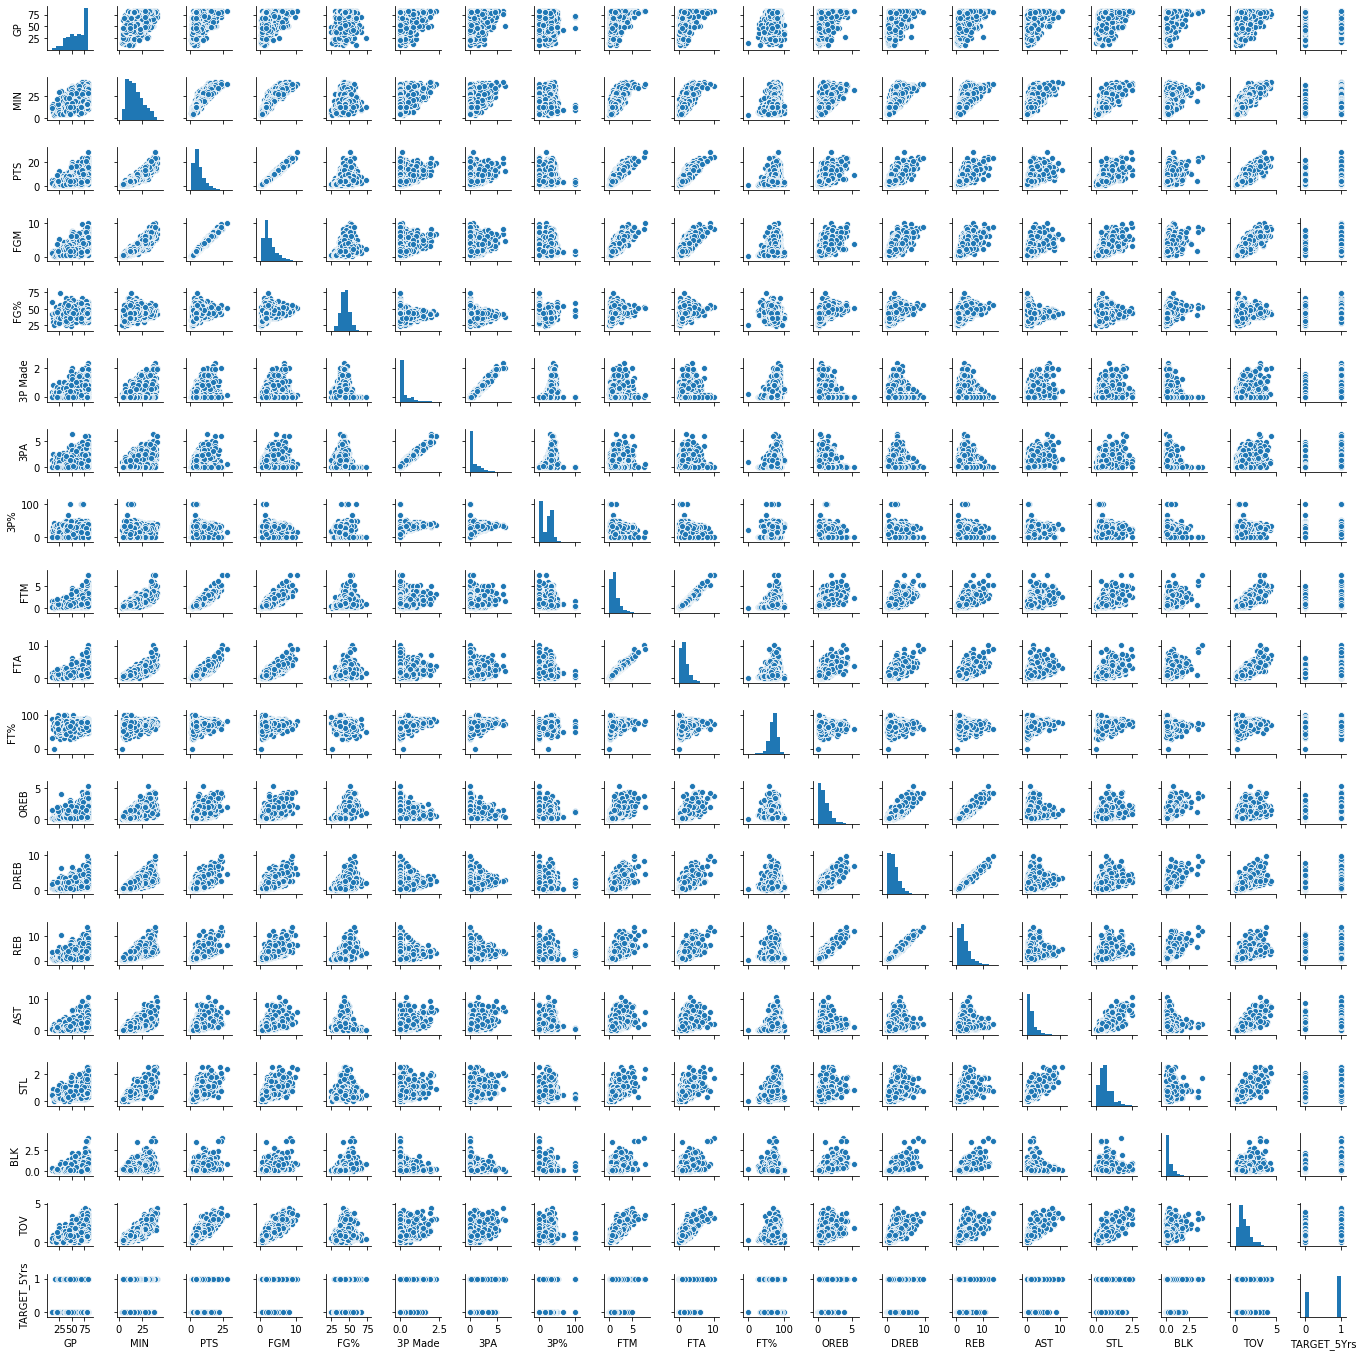

In [99]:
sns.pairplot(nba_copy, size=1);

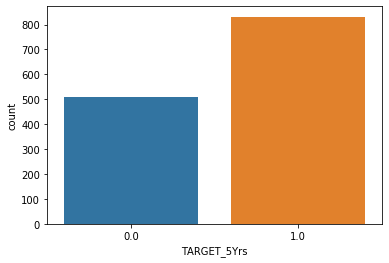

In [102]:
sns.countplot("TARGET_5Yrs", data = nba)

In [0]:
# sns.factorplot("GP", "TARGET_5Yrs", hue = "MIN", data = nba)
# plt.show()

Start of the train/val/test split
---

In [0]:
X = nba.drop(columns='TARGET_5Yrs')
y = nba['TARGET_5Yrs']

In [0]:
def train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, random_state=1)

In [17]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1005, 20), (134, 20), (201, 20), (1005,), (134,), (201,))

In [23]:
processor = make_pipeline(ce.OrdinalEncoder(), SimpleImputer(strategy='mean'))
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBClassifier(n_estimators=100, n_jobs=-1)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='error', early_stopping_rounds=20)

[0]	validation_0-error:0.267662	validation_1-error:0.313433
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.273632	validation_1-error:0.320896
[2]	validation_0-error:0.272637	validation_1-error:0.313433
[3]	validation_0-error:0.262687	validation_1-error:0.298507
[4]	validation_0-error:0.258706	validation_1-error:0.291045
[5]	validation_0-error:0.253731	validation_1-error:0.291045
[6]	validation_0-error:0.262687	validation_1-error:0.30597
[7]	validation_0-error:0.257711	validation_1-error:0.30597
[8]	validation_0-error:0.249751	validation_1-error:0.298507
[9]	validation_0-error:0.253731	validation_1-error:0.298507
[10]	validation_0-error:0.258706	validation_1-error:0.298507
[11]	validation_0-error:0.247761	validation_1-error:0.298507
[12]	validation_0-error:0.252736	validation_1-error:0.291045
[13]	validation_0-error:0.248756	validation_1-error:0.2910

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [24]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7197368421052631


In [54]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42,
                           max_depth=5)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.7532338308457711
Validation Accuracy 0.6567164179104478


visuals
---

In [25]:
random_number = 43

row = X_val.iloc[[random_number]]

row

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
783,Corey Brewer,79,22.796875,5.800781,2.300781,6.199219,37.40625,0.099976,0.5,19.40625,1.099609,1.400391,80.0,1.0,2.699219,3.699219,1.400391,1.0,0.300049,1.099609


In [26]:
row_transformed = transformers.transform(row)

row_transformed

array([[2.47000000e+02, 7.90000000e+01, 2.27968750e+01, 5.80078125e+00,
        2.30078125e+00, 6.19921875e+00, 3.74062500e+01, 9.99755859e-02,
        5.00000000e-01, 1.94062500e+01, 1.09960938e+00, 1.40039062e+00,
        8.00000000e+01, 1.00000000e+00, 2.69921875e+00, 3.69921875e+00,
        1.40039062e+00, 1.00000000e+00, 3.00048828e-01, 1.09960938e+00]])

In [27]:
y_val.iloc[[random_number]]

783    1.0
Name: TARGET_5Yrs, dtype: float16

In [28]:
model.predict(row_transformed)

array([1.], dtype=float16)

In [29]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_transformed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

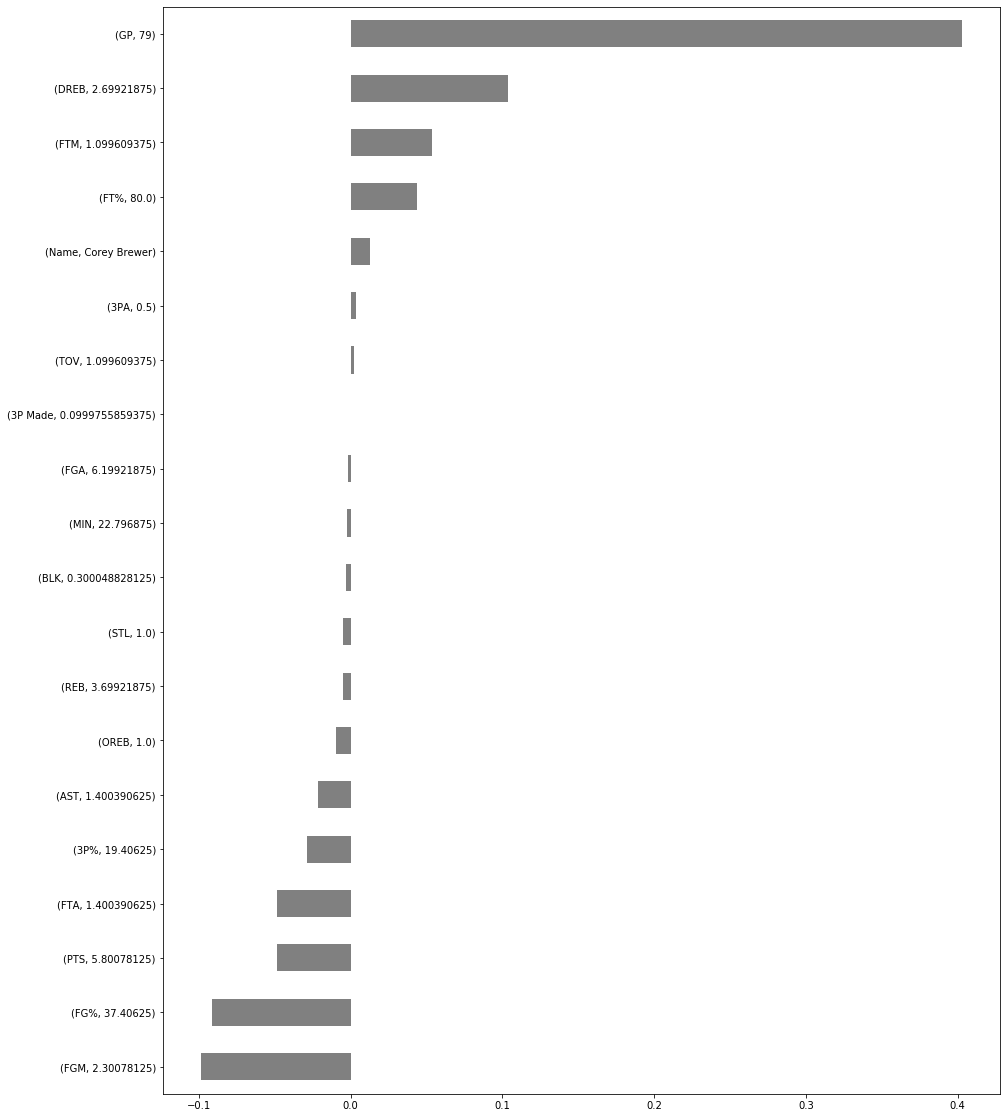

In [30]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));

In [31]:
permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', n_iter=3)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0945 ± 0.1152,GP
0.0299 ± 0.0122,OREB
0.0199 ± 0.0253,FTM
0.0175 ± 0.0140,FT%
0.0150 ± 0.0212,3P%
0.0125 ± 0.0187,PTS
0.0100 ± 0.0187,FGA
0.0099 ± 0.0140,REB
0.0075 ± 0.0122,FG%
0.0025 ± 0.0071,Name


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


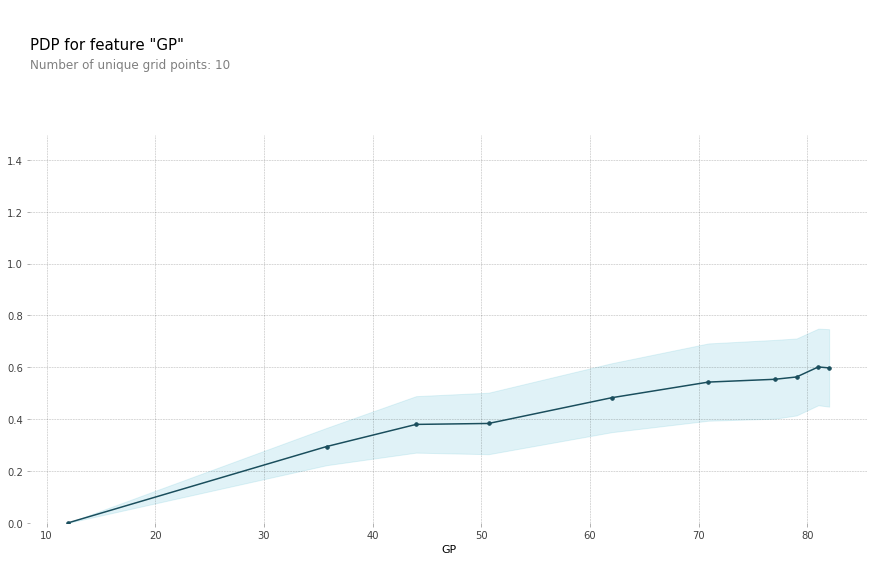

In [33]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'GP'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

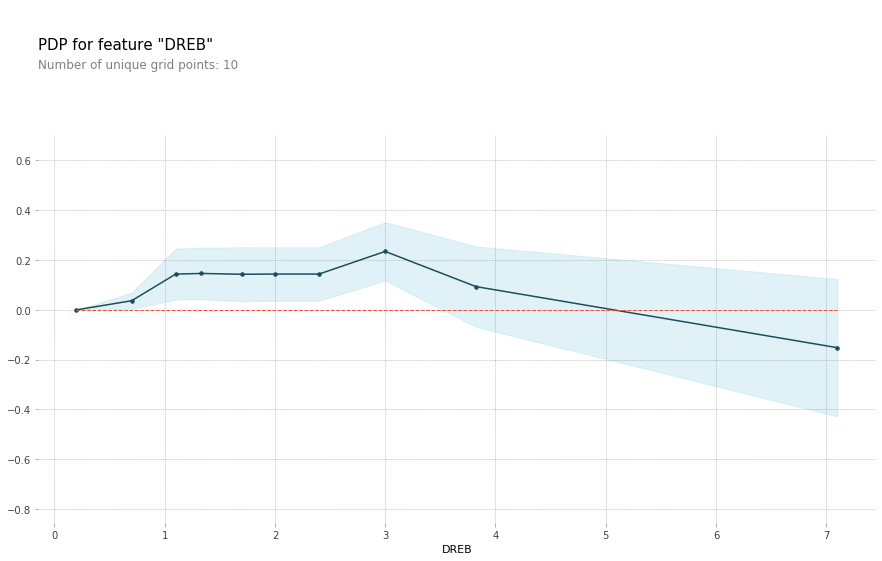

In [34]:
feature = 'DREB'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

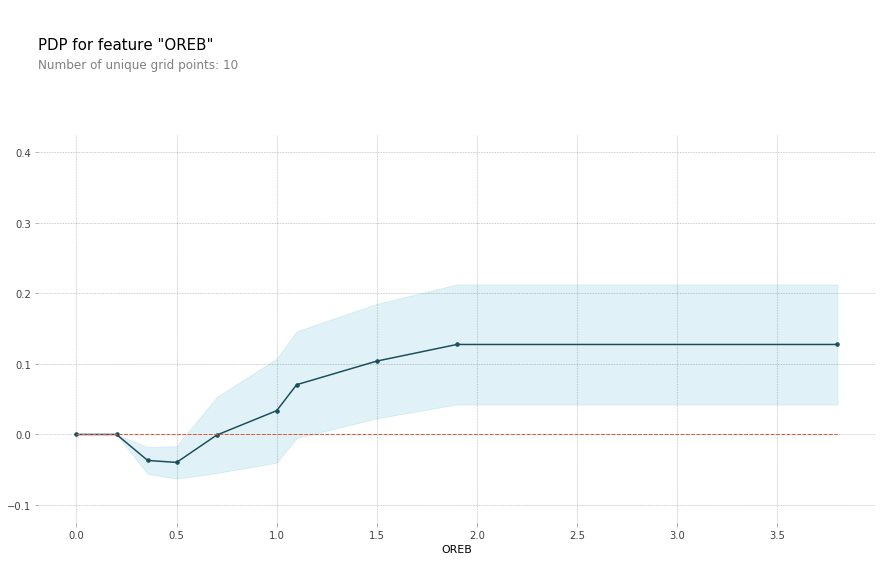

In [35]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'OREB'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

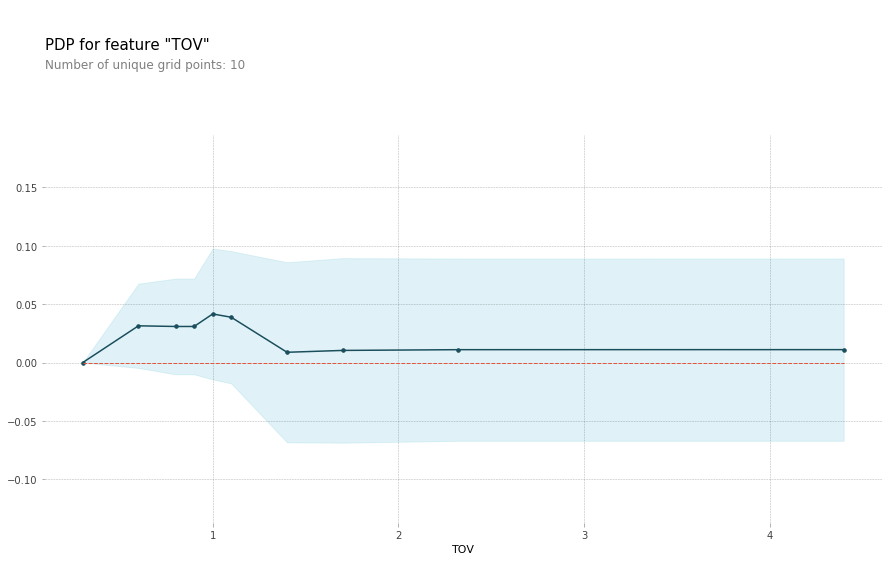

In [36]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'TOV'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [38]:
# We need to get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array([0., 1.], dtype=float16)

Dropping features
---

In [0]:
nba_copy = nba.drop(columns='DREB')

In [0]:
nba_copy = nba.drop(columns='TOV')

In [0]:
nba_copy = nba.drop(columns='MIN')

In [0]:
nba_copy = nba.drop(columns='AST')

In [0]:
nba_copy = nba.drop(columns='FTA')

In [0]:
nba_copy = nba.drop(columns='3P Made')

In [0]:
nba_copy = nba.drop(columns='3PA')

In [0]:
nba_copy = nba.drop(columns='BLK')

In [0]:
nba_copy = nba.drop(columns='FGM')

In [0]:
nba_copy = nba.drop(columns='STL')

In [0]:
nba_copy = nba.drop(columns='Name')

In [0]:
nba_copy = nba.drop(columns='FG%')

In [0]:
nba_copy = nba.drop(columns='REB')

In [0]:
nba_copy = nba.drop(columns='FGA')

New accuracy score
---

In [0]:
X = nba_copy.drop(columns='TARGET_5Yrs')
y = nba_copy['TARGET_5Yrs']

In [0]:
def train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, random_state=1)

In [81]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1005, 19), (134, 19), (201, 19), (1005,), (134,), (201,))

In [82]:
processor = make_pipeline(ce.OrdinalEncoder(),
                          SimpleImputer(strategy='mean'))
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBClassifier(n_estimators=100, 
                      n_jobs=-1)

model.fit(X_train_transformed, 
          y_train, 
          eval_set=eval_set, 
          eval_metric='error', 
          early_stopping_rounds=20)

[0]	validation_0-error:0.267662	validation_1-error:0.313433
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.273632	validation_1-error:0.320896
[2]	validation_0-error:0.272637	validation_1-error:0.313433
[3]	validation_0-error:0.262687	validation_1-error:0.298507
[4]	validation_0-error:0.258706	validation_1-error:0.291045
[5]	validation_0-error:0.253731	validation_1-error:0.291045
[6]	validation_0-error:0.264677	validation_1-error:0.30597
[7]	validation_0-error:0.263682	validation_1-error:0.30597
[8]	validation_0-error:0.254726	validation_1-error:0.298507
[9]	validation_0-error:0.257711	validation_1-error:0.298507
[10]	validation_0-error:0.260697	validation_1-error:0.298507
[11]	validation_0-error:0.254726	validation_1-error:0.30597
[12]	validation_0-error:0.250746	validation_1-error:0.298507
[13]	validation_0-error:0.251741	validation_1-error:0.29850

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7173157894736842


In [84]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42,
                           max_depth=5)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.7532338308457711
Validation Accuracy 0.6567164179104478
